# Comparison of Different Algorithmic Trading Strategies on Tesla Stock Price

### Tawfiq Jawhar
<b>Machine Learning (COMP-652 and ECSE-608)<br>
Fall 2018<br>
McGill University <br><br>
Instructors:<br>
Audrey Durand<br>
Riashat Islam <br></b>

---

## Outline
The Tesla stock price is an intersting choice to explore and test different algorithmic strategies on. In this notebook, I analyze TSLA and discover any trends or regines in the data that will help design a model to predict the price or movement of TSLA. 
This work is inspired from Brain's notebooks [Mixture Model Trading.](https://github.com/BlackArbsCEO/mixture_model_trading_public)

In [37]:
## inline plot
%matplotlib inline

##import libraries
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
import dateutil.parser
import numpy as np 
import scipy.stats as stats

plt.style.use('seaborn-talk')
plt.style.use('bmh')
plt.rcParams['font.weight'] = 'medium'
plt.rcParams['figure.figsize'] = 10,7
colors = sns.color_palette('colorblind', 6)

In [8]:
## load the TSLA price data
df = pd.read_pickle('data/TSLAtraining.pickle')
TSLA = df['TSLA']


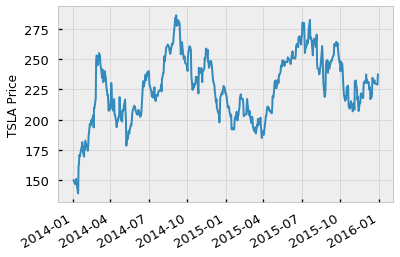

In [10]:
TSLA.plot()
plt.ylabel("TSLA Price")
plt.xlabel("")

plt.show()

The price of the TSLA stock is a difficult signal to predict or find trends in. It is clear that the price signal is non stationary. This can be seen better by looking at the return from each day to the other. 

We will use the logarithmic return instead of the ordinary return. Logarithmic return is usually used in finance because it is symmetrical. For example, if an investment of $\$$100 that has a logarithmic return of +50\% then -50\%, the return value will be $\$$100. 

$$ LogarithmicReturn = \log{(\frac{V_{t+1}}{V_t})} $$

Where $V_x$ is the value at time $x$

In [11]:
returns = np.log(TSLA/TSLA.shift(1)).dropna()


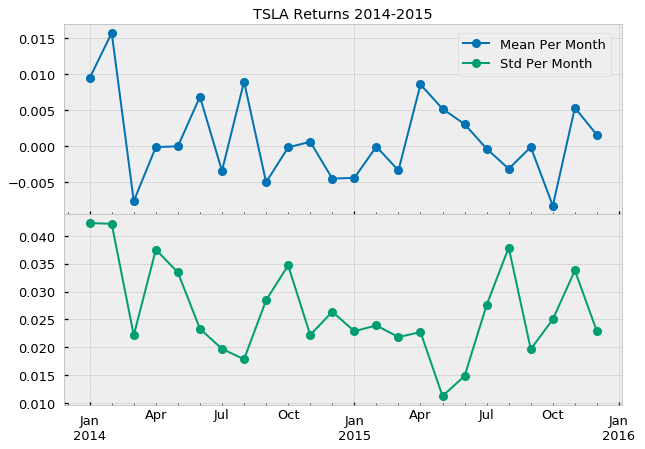

In [13]:
f,axes = plt.subplots(2, sharex=True, figsize=(10,7))
returns.groupby(returns.index.to_period('M')).agg(['mean']).plot(ax=axes[0],marker='o',color=colors[0])
returns.groupby(returns.index.to_period('M')).agg(['std']).plot(ax=axes[1],marker='o',color=colors[2])
#axes[0].legend(['Mean Per Month','Std Per Month'], bbox_to_anchor=(1.0, .6))
axes[1].legend().set_visible(False)
axes[0].legend().set_visible(False)

axes[0].set_title('TSLA Returns 2014-2015')
#axes[1].set_title('Std by Month');
axes[1].set_xlabel("")
handles1, labels = axes[0].get_legend_handles_labels()
handles2, labels = axes[1].get_legend_handles_labels()

f.subplots_adjust(hspace=0)
frame = f.legend(handles1+handles2,('Mean Per Month','Std Per Month'),loc = [0.71,0.83]).get_frame()
#frame.set_facecolor('lightgrey')
#axes[0].set_facecolor('')
#plt.tight_layout()

plt.show()

We can see that that the monthly mean and std of the logarithmic return varies from one month to the other. 
This can tell us that returns are not coming from the same distribution. 
However, let's visualize the kernel density estimates over different period of times throughout 2014-2015. We will use `sns.kdeplot`.

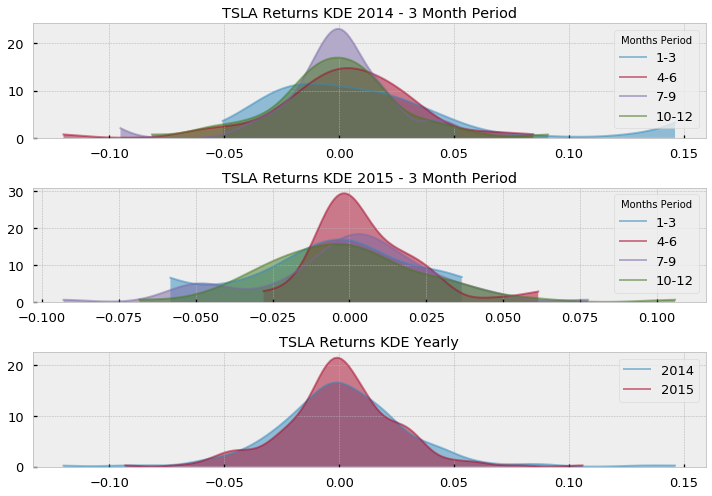

In [17]:
years = [2014,2015]
months = [1,4,7,10]
f, axes = plt.subplots(nrows=3, figsize=(10,7))
i=0
for year in years:
    for month in months:
        #print(month)aa
        firstMonth = str(year)+'-'+str(month)+'-01'
        if month != 10:
            lastMonth = str(year)+'-'+str(month+3)+'-01'
        else: lastMonth = str(year+1)+'-01-01'
        sns.kdeplot(returns[(returns.index >= firstMonth) & (returns.index < lastMonth)], ax=axes[i],
                    shade=True, label=str(month)+'-'+str(month+2), cut=0, alpha=0.5)
    i+=1
for year in years:
    #print(month)
    firstMonth = str(year)+'-01-01'
    lastMonth = str(year+1)+'-01-01'
    sns.kdeplot(returns[(returns.index >= firstMonth) & (returns.index < lastMonth)], ax=axes[i],
                shade=True, label=str(year), cut=0, alpha=0.5)
#axes[0].legend(bbox_to_anchor=(0.9, 0.9))

axes[0].set_title('TSLA Returns KDE 2014 - 3 Month Period')
axes[0].legend(loc='upper right', title="Months Period")

axes[1].legend(loc='upper right', title="Months Period")
axes[1].set_title('TSLA Returns KDE 2015 - 3 Month Period')

axes[2].set_title("TSLA Returns KDE Yearly")
plt.tight_layout()
plt.show()

The distributions are obviously different with different means and variances. However, it is intersting to see that the kde of 2014 returns are close to following a Normal distribution. 
It is also intersting to observe in the 2015 returns the two small curves at return &asymp; -0.05 and 0.03. 

This looks similar to a mixture of distributions. <b> Can we cluster the returns to find different distributions in the return?? </b>

Before we do that, let's confirm our hypothesis using Kolmogorov-Smirnov to test if the yearly returns follow a Normal distribution.

<h1 style="color: #5e9ca0;">Null Hypothesis: <span style="color: #2b2301;">The logarithmic returns for TSLA follow a Normal Distribution.</h1>

## Kolmogorov-Smirnov Test

We will compare the CDF of our returns with the CDF of samples coming from a Normal distribution with the same mean and variance of our returns. 

We will do the same test over the 2 year period and for each year seperately. If the p-value of the ks-test is less than 0.05 then we can be confident to reject the null hypothesis. 

In [107]:
#taken from (https://github.com/BlackArbsCEO/mixture_model_trading_public/blob/master/notebooks/01.%20Motivation-updated.ipynb)
#modified a bit
def plot_cdf(ser, ax):   
    """fn: to plot single CDF comparison
    
    Params
    ------
        ser : pd.Series()
    """
    def generate_norm_cdf(ser, N=None):
        if not N: N = ser.shape[0]
        x = np.linspace(ser.min(), ser.max(), N)
        y = stats.norm.cdf(x, ser.mean(), ser.std())
        return x, y
       
    # plot kde
    g = sns.kdeplot(ser, cumulative=True, lw=3, color=colors[3], ax=ax)
    
    x, y = generate_norm_cdf(ser) # generate fitted normal CDF
    g.plot(x, y, color=colors[0], lw=3, label='fitted normal CDF')
    
    # two sided ks test
    #  https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kstest.html
    ks, p = stats.kstest(ser, 'norm', args=(ser.mean(), ser.std()))
    
    xmin,xmax=ax.get_xlim()
    ymin,ymax=ax.get_ylim()

    # add text
    txkw = dict(size=14, fontweight='medium', color='k', rotation=0)
    tx_N = ser.shape[0]
    tx_args = (ks, p, tx_N, ser.shape[0])
    tx = """
    ks: {:.4f}, p: {:.4f}
    rvs sample N: {:.0f}
    return sample N: {:.0f}
    """.format(*tx_args)
    ax.text(xmax*0.2, 0.2*ymax, tx, **txkw)    
    
    #sns.despine(offset=1)
    (ax.legend(frameon=True, prop={'weight':'demi', 'size':12})
     .get_frame()
     .set_edgecolor(colors[3]))
    return

def plot_facet_cdf(ser, sym, **kwds):
    f, axes = plt.subplots(nrows=3, figsize=(7,10))
    plot_cdf(returns,ax=axes[0])
    
    years=[2014,2015]
    i=1
    for year in years:
        firstMonth = str(year)+'-01-01'
        lastMonth = str(year+1)+'-01-01'
        plot_cdf(returns[(returns.index >= firstMonth) & (returns.index < lastMonth)], ax=axes[i])
        i+=1


    
    sns.despine(offset=1)
    axes[0].set_title("KS Two-Sided Test 2014-2015")
    axes[1].set_title("KS Two-Sided Test 2014")
    axes[2].set_title("KS Two-Sided Test 2015")

    plt.tight_layout()
    return

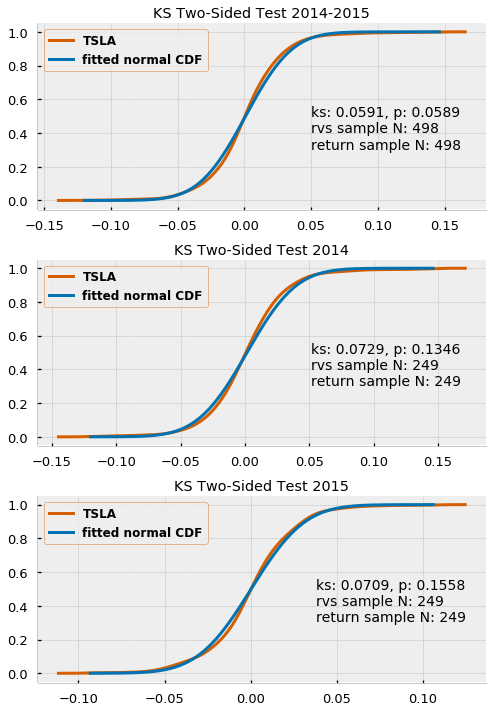

In [108]:
plot_facet_cdf(returns, 'TSLA')


This confirms that the TSLA returns are drawn from a distribution different than the Normal distribution.

## Conclusion
The exploration shows us that the TSLA price return is non stationary and does not follow a Normal distribution. Which makes it hard to predict. However, we also noticed when visualizing the KDE some hidden distributions in the returns. 
<br><b> Can we detect different regimes in the return?</b>